## Team Challenge Part 2: Automated landmark placement

In [177]:
"""
Code is provided by Adaloglou Nikolas (2021)

https://github.com/black0017/ct-intensity-segmentation

"""
import os
import csv
import cv2
import glob
import math
import time
import shutil

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from skimage import measure
from PIL import Image, ImageDraw
from scipy.spatial import ConvexHull


def show_slice(slice):
    """
    Function to display an image slice
    Input is a numpy 2D array
    """
    plt.figure()
    plt.imshow(slice.T, cmap="gray", origin="lower")

def overlay_plot(im, mask):
    plt.figure()
    plt.imshow(im.T, 'gray', interpolation='none')
    plt.imshow(mask.T, 'jet', interpolation='none', alpha=0.5)
    
def make_dirs(path):
    """
    Creates the directory as specified from the path
    in case it exists it deletes it
    """
    if os.path.exists(path):
        shutil.rmtree(path)
        os.mkdir(path)
    else:
        os.makedirs(path)

def intensity_seg(ct_numpy, min, max):
    clipped = ct_numpy.clip(min, max)
    clipped[clipped != max] = 1
    clipped[clipped == max] = 0
    return measure.find_contours(clipped, 0.95)

def set_is_closed(contour):
    if contour_distance(contour) < 1:
        return True
    else:
        return False

def find_lungs(contours):
    """
    Chooses the contours that correspond to the lungs and the body
    FIrst we exclude non closed sets-contours
    Then we assume some min area and volume to exclude small contours
    Then the body is excluded as the highest volume closed set
    The remaining areas correspond to the lungs

    Args:
        contours: all the detected contours

    Returns: contours that correspond to the lung area

    """
    body_and_lung_contours = []
    vol_contours = []

    for contour in contours:
        hull = ConvexHull(contour)

        if hull.volume > 2000 and set_is_closed(contour):
            body_and_lung_contours.append(contour)
            vol_contours.append(hull.volume)

    if len(body_and_lung_contours) == 2:
        return body_and_lung_contours
    elif len(body_and_lung_contours) > 2:
        vol_contours, body_and_lung_contours = (list(t) for t in
                                                zip(*sorted(zip(vol_contours, body_and_lung_contours))))
        body_and_lung_contours.pop(-1)
        return body_and_lung_contours


def show_contour(image, contours, name=None, save=False):
    fig, ax = plt.subplots()
    ax.imshow(image.T, cmap=plt.cm.gray)
    for contour in contours:
        ax.plot(contour[:, 0], contour[:, 1], linewidth=1)

    ax.set_xticks([])
    ax.set_yticks([])

    if save:
        plt.savefig(name)
        plt.close(fig)
    else:
        plt.show()

def create_mask_from_polygon(image, contours):
    """
    Creates a binary mask with the dimensions of the image and
    converts the list of polygon-contours to binary masks and merges them together
    Args:
        image: the image that the contours refer to
        contours: list of contours

    Returns:

    """
    lung_mask = np.array(Image.new('L', image.shape, 0))
    for contour in contours:
        x = contour[:, 0]
        y = contour[:, 1]
        polygon_tuple = list(zip(x, y))
        img = Image.new('L', image.shape, 0)
        ImageDraw.Draw(img).polygon(polygon_tuple, outline=0, fill=1)
        mask = np.array(img)
        lung_mask += mask

    lung_mask[lung_mask > 1] = 1  # sanity check to make 100% sure that the mask is binary

    return lung_mask.T  # transpose it to be aligned with the image dims

def save_nifty(img_np, name, affine):
    """
    binary masks should be converted to 255 so it can be displayed in a nii viewer
    we pass the affine of the initial image to make sure it exits in the same
    image coordinate space
    Args:
        img_np: the binary mask
        name: output name
        affine: 4x4 np array
    Returns:
    """
    img_np[img_np == 1] = 255
    ni_img = nib.Nifti1Image(img_np, affine)
    nib.save(ni_img, name + '.nii.gz')

def find_pix_dim(ct_img):
    """
    Get the pixdim of the CT image.
    A general solution that get the pixdim indicated from the image
    dimensions. From the last 2 image dimensions we get their pixel dimension.
    Args:
        ct_img: nib image

    Returns: List of the 2 pixel dimensions
    """
    pix_dim = ct_img.header["pixdim"]
    dim = ct_img.header["dim"]
    max_indx = np.argmax(dim)
    pixdimX = pix_dim[max_indx]
    dim = np.delete(dim, max_indx)
    pix_dim = np.delete(pix_dim, max_indx)
    max_indy = np.argmax(dim)
    pixdimY = pix_dim[max_indy]
    return [pixdimX, pixdimY]

def contour_distance(contour):
    """
    Given a set of points that may describe a contour
     it calculates the distance between the first and the last point
     to infer if the set is closed.
    Args:
        contour: np array of x and y points

    Returns: euclidean distance of first and last point
    """
    dx = contour[0, 1] - contour[-1, 1]
    dy = contour[0, 0] - contour[-1, 0]
    return np.sqrt(np.power(dx, 2) + np.power(dy, 2))

def compute_area(mask, pixdim):
    """
    Computes the area (number of pixels) of a binary mask and multiplies the pixels
    with the pixel dimension of the acquired CT image
    Args:
        lung_mask: binary lung mask
        pixdim: list or tuple with two values

    Returns: the lung area in mm^2
    """
    mask[mask >= 1] = 1
    lung_pixels = np.sum(mask)
    return lung_pixels * pixdim[0] * pixdim[1]

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

def get_line(x1,y1,x2,y2):

    line = []
    
    a = (y1-y2)/(x1-x2) # Slope
    b = (x1*y2 - x2*y1)/(x1-x2)
         
    for x in range(x1,x2):
        y = a*x + b
        line.append([round(y),x])
         
    return line

# Load data

In [178]:
# Define paths -> You may need to change these
MAIN_PATH = os.path.abspath('')
cso_file = os.path.join(MAIN_PATH,'Scoliose/1preop.cso') 
nifti_file = os.path.join(MAIN_PATH,'Scoliose/1preop.nii')

# Load image data
ct_input = nib.load(nifti_file)
ct_img = ct_input.get_fdata()
ct_img = np.rot90(ct_img)

# Automated landmarks and surface1

276 316


Text(0.5, 1.0, 'Surface area 1')

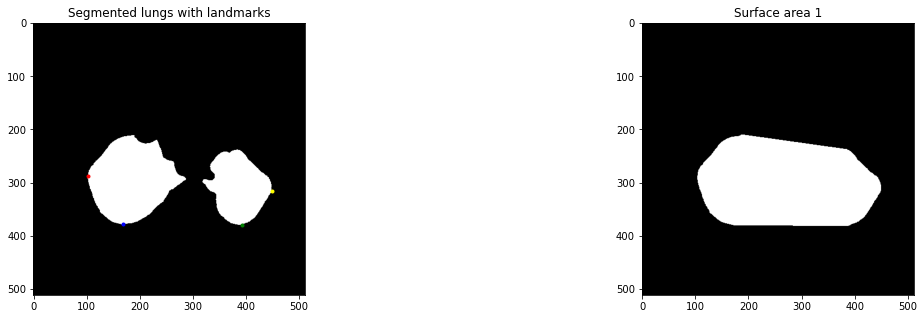

In [184]:
# Automated landmark placement one slice

# TODO:
# - Loop over each slice
# - Exclude "empty" slices
# - Store the landmarks
# - Validation

slice = 320
ct_numpy = ct_img[:,:,slice]

# Get the coordinates of the lung countours and create the mask
contours = intensity_seg(ct_numpy, min=-1000, max=-300) # Hounsfields units
lung_contours = find_lungs(contours)
lung_mask = np.array(create_mask_from_polygon(ct_numpy, lung_contours))

# Separate the left and right lung
left_lung, right_lung = np.rot90(lung_contours[0],2).astype(int), np.rot90(lung_contours[1],2).astype(int)

# Check if the labeling of the lung is correct
if left_lung[0,0] > right_lung[0,0]: # first coordinate is the most bottom maximum in the lungs
    store_left_lung = left_lung
    left_lung = right_lung
    right_lung = store_left_lung
    
# Get maxima
x_LL, y_LL = left_lung[:, 0], left_lung[:, 1]
x_RL, y_RL = right_lung[:, 0], right_lung[:, 1]

idx_bottom_LL = np.argmax(y_LL)
idx_top_LL = np.argmin(y_LL)
idx_left_LL = np.argmin(x_LL)
idx_right_LL = np.argmax(x_LL)

idx_bottom_RL = np.argmax(y_RL)
idx_top_RL = np.argmin(y_RL)
idx_left_RL = np.argmin(x_RL)
idx_right_RL = np.argmax(x_RL)

# Landmarks
p1 = x_LL[idx_left_LL], y_LL[idx_left_LL]
p3 = x_RL[idx_right_RL], y_RL[idx_right_RL]
p6 = x_LL[idx_bottom_LL], y_LL[idx_bottom_LL]
p8 = x_RL[idx_bottom_RL], y_RL[idx_bottom_RL]

# Plot the segmented lungs with landmarks
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].imshow(lung_mask, cmap='gray')
ax[0].set_title('Segmented lungs with landmarks')
ax[0].plot(p1[0], p1[1], marker='o', markersize=3, color="red")
ax[0].plot(p3[0], p3[1], marker='o', markersize=3, color="yellow")
ax[0].plot(p6[0], p6[1], marker='o', markersize=3, color="blue")
ax[0].plot(p8[0], p8[1], marker='o', markersize=3, color="green")

# # Other maxima
# ax[0].plot(x_LL[idx_top_LL], y_LL[idx_top_LL], marker='o', markersize=3, color="lightblue")
# ax[0].plot(x_LL[idx_right_LL], y_LL[idx_right_LL], marker='o', markersize=3, color="purple")
# ax[0].plot(x_RL[idx_top_RL], y_RL[idx_top_RL], marker='o', markersize=3, color="lightgreen")
# ax[0].plot(x_RL[idx_left_RL], y_RL[idx_left_RL], marker='o', markersize=3, color="orange")

# Connect the lungs for floodfill
line_1 = get_line(x_LL[idx_top_LL],y_LL[idx_top_LL],x_RL[idx_top_RL],y_RL[idx_top_RL])
line_2 = get_line(p6[0],p6[1],p8[0],p8[1])

for y,x in line_1:
    for i in range(10):
        lung_mask[y+i,x] = 1

for y,x in line_2:
    for i in range(10):
        lung_mask[y-i,x] = 1
        
# Get center of the surface
center_x = round((p1[0]+p3[0])/2)
# center_y = round((y_LL[idx_top_LL]+p6[1])/2) # Tried this one first, but doesn't work on all
center_y = p3[1]

# print(center_x,center_y)

# Apply morphological closing
kernel_size = (10,10)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,kernel_size)
area = flood_fill(lung_mask, (center_x,center_y), 1)
surface1 = cv2.morphologyEx(area, cv2.MORPH_CLOSE, kernel)

# ax[1].imshow(lung_mask, cmap='gray')
ax[1].imshow(surface1, cmap='gray')
ax[1].set_title('Surface area 1')

# Visualize 2D lung segmentation

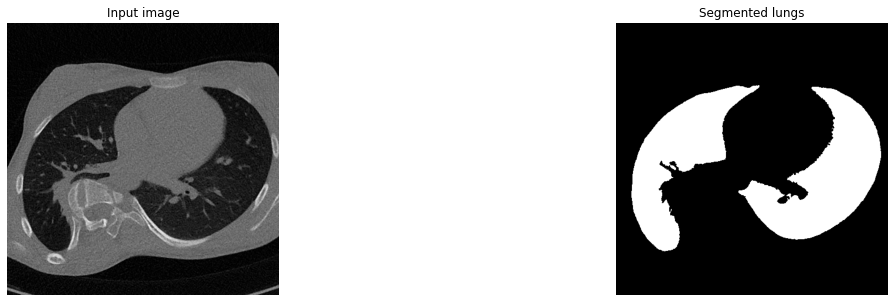

In [189]:
# Lung segmentation
slice = 200

ct_numpy = ct_img[:,:,slice]
contours = intensity_seg(ct_numpy, min=-1000, max=-300) # Hounsfields units
lungs = find_lungs(contours)
if lungs:
    lung_mask = create_mask_from_polygon(ct_numpy, lungs)

# Plot the images
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].imshow(ct_numpy, cmap='gray')
ax[0].set_title('Input image')

if lungs:
    ax[1].imshow(lung_mask, cmap='gray')
    ax[1].set_title('Segmented lungs')
else:
    ax[1].set_title('No lungs found')
    
[x.set_axis_off() for x in ax]
plt.show()

# Exclude empty slices

In [188]:
lung_seg = np.zeros(ct_img.shape)
empty_slices = np.array([])

# Get the lung segmentation for each slice and store them
for slice in range(ct_img.shape[2]):
    ct_numpy = ct_img[:,:,slice]
    contours = intensity_seg(ct_numpy, min=-1000, max=-300) # Hounsfields units
    lungs = find_lungs(contours)
    if lungs:
        lung_mask = create_mask_from_polygon(ct_numpy, lungs)
        lung_seg[:,:,slice] = lung_mask
    else:
        empty_slices = np.append(empty_slices,slice)
        
# Exclude slices without lungs
empty_slices_list = empty_slices.astype(int).tolist()
#print(empty_slices_list)
ct_numpy_no_empty_slices = np.delete(ct_img, empty_slices_list, 2)
lung_seg_no_emtpy_slices = np.delete(lung_seg, empty_slices_list, 2)

print('All slices: ',lung_seg.shape)
print('Only lung:  ',lung_seg_no_emtpy_slices.shape)

All slices:  (512, 512, 437)
Only lung:   (512, 512, 281)
